In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/the-climate-change-twitter-dataset/The Climate Change Twitter Dataset.csv
/kaggle/input/the-climate-change-twitter-dataset/disasters.csv


In [2]:
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
    Input, Embedding, LSTM, GRU, SimpleRNN,
    Dense, Dropout, Flatten, BatchNormalization,
    GlobalAveragePooling2D, LeakyReLU
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import GlobalAveragePooling1D
from tensorflow.keras.layers import Input, LSTM, Dense, Bidirectional, Dropout, BatchNormalization
from tensorflow.keras.layers import Input, LSTM, Bidirectional, Dropout, BatchNormalization, Attention, Add, Dense, LeakyReLU
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Attention
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import random


2025-04-18 19:02:35.455631: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745002955.645457      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745002955.700202      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# 📌 Dataset Summary
* Dataset Size: 5.3 million rows, 10 columns (5307538, 10)

* Data Cleaning: Missing data (NaN) was cleaned and appropriate data types (e.g. date, categorical data) were converted.

* Target Variable: Aggressiveness (0 = not aggressive, 1 = aggressive)

* Objective: To classify tweets as aggressive or not, given geographical, temporal and content-based features.

# DATA

In [3]:
df = pd.read_csv(r"/kaggle/input/the-climate-change-twitter-dataset/The Climate Change Twitter Dataset.csv")

In [4]:
df.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,created_at,id,lng,lat,topic,sentiment,stance,gender,temperature_avg,aggressiveness
0,2006-06-06 16:06:42+00:00,6132,NaN,NaN,Weather Extremes,-0.097180,neutral,female,NaN,aggressive
1,2006-07-23 21:52:30+00:00,13275,-73.949582,40.650104,Weather Extremes,0.575777,neutral,undefined,-1.114768,aggressive
2,2006-08-29 01:52:30+00:00,23160,NaN,NaN,Weather Extremes,0.500479,neutral,male,NaN,aggressive
3,2006-11-07 02:46:52+00:00,57868,NaN,NaN,Weather Extremes,0.032816,neutral,male,NaN,aggressive
4,2006-11-27 14:27:43+00:00,304553,NaN,NaN,Importance of Human Intervantion,-0.090428,neutral,male,NaN,aggressive


In [5]:
df.isna().sum()

created_at                0
id                        0
lng                10481873
lat                10481873
topic                     0
sentiment                 0
stance                    0
gender                    0
temperature_avg    10481873
aggressiveness            0
dtype: int64

In [6]:
df.dropna(inplace=True)

In [7]:
df.shape

(5307538, 10)

In [8]:
df['created_at'] = pd.to_datetime(df['created_at'])

In [9]:
for col in ['topic', 'stance', 'gender']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))


In [10]:
df['year'] = df['created_at'].dt.year
df['month'] = df['created_at'].dt.month
df['day'] = df['created_at'].dt.day
df['hour'] = df['created_at'].dt.hour


In [11]:
df['aggressiveness'] = df['aggressiveness'].map({'aggressive': 1, 'not aggressive': 0})


In [12]:
features = ['year', 'month', 'day', 'hour', 'lng', 'lat',
            'sentiment', 'temperature_avg', 'topic', 'stance', 'gender']
X = df[features]
y = df['aggressiveness']


In [13]:
df.head()

,created_at,id,lng,lat,topic,sentiment,stance,gender,temperature_avg,aggressiveness,year,month,day,hour
1,2006-07-23 21:52:30+00:00,13275,-73.949582,40.650104,9,0.575777,2,2,-1.114768,1,2006,7,23,21
7,2006-12-14 01:39:10+00:00,1092823,-122.419420,37.774930,2,-0.544195,2,1,4.228540,1,2006,12,14,1
8,2006-12-17 19:43:09+00:00,1278023,-79.791980,36.072640,9,-0.565028,1,1,5.478175,1,2006,12,17,19
9,2006-12-21 01:39:01+00:00,1455543,-121.805790,38.004920,9,0.650960,2,1,-1.652156,0,2006,12,21,1
11,2006-12-31 10:47:25+00:00,1893063,-1.902691,52.479699,9,0.670905,2,1,4.864521,1,2006,12,31,10


# EDA

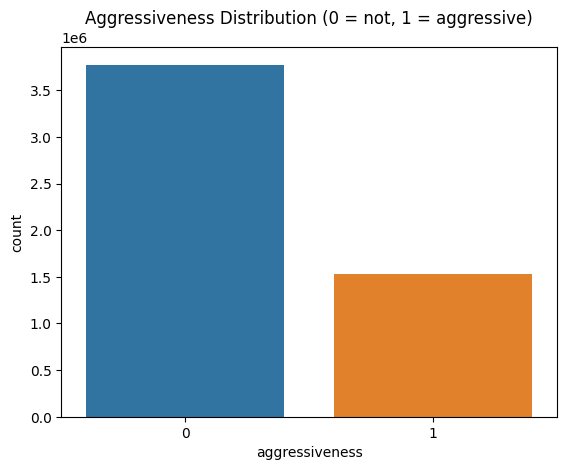

In [14]:
sns.countplot(data=df, x='aggressiveness')
plt.title("Aggressiveness Distribution (0 = not, 1 = aggressive)")
plt.show()

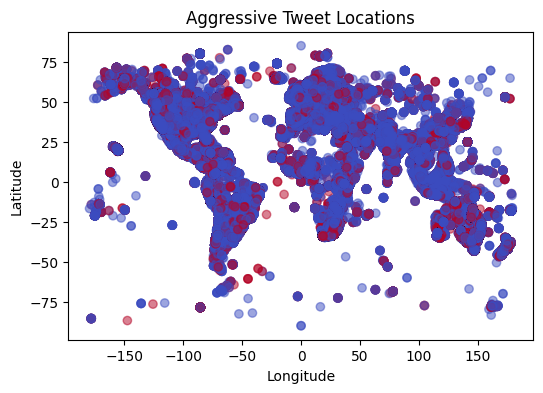

In [15]:
plt.figure(figsize=(6, 4))
plt.scatter(df['lng'], df['lat'], c=df['aggressiveness'], cmap='coolwarm', alpha=0.5)
plt.title("Aggressive Tweet Locations")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

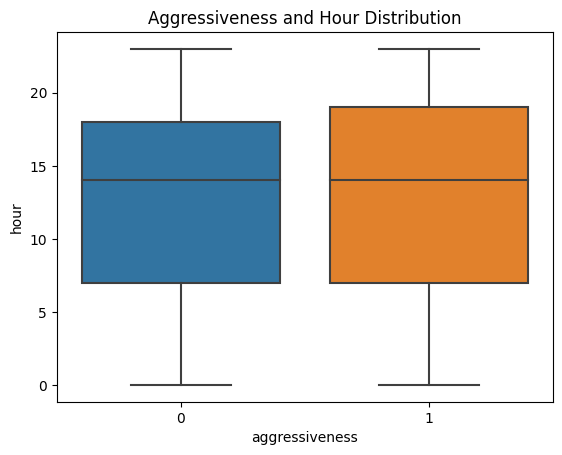

In [16]:
sns.boxplot(data=df, x='aggressiveness', y='hour')
plt.title("Aggressiveness and Hour Distribution")
plt.show()

# MIN MAX SCALER


In [17]:
scaler = MinMaxScaler()

X_scaled = scaler.fit_transform(X)

# DATA FOR LSTM

In [18]:
X_scaled = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1])) 

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


# RNN - LSTM MODEL

In [20]:
def lstm_block(x, units, return_sequences = False , dp = 0.4):
    residual = x 
    x = Bidirectional(LSTM(units,return_sequences=True , kernel_regularizer=l2(0.001)))(x)
    x = Dropout(dp)(x)
    x = BatchNormalization()(x)

    attentiob = Attention()([x,x])
    x = Add()([x,attentiob])

    if residual.shape[-1] != x.shape[-1]:
        residual = Dense(x.shape[-1])(residual)
    x = Add()([x,residual])

    if not return_sequences:
        x = GlobalAveragePooling1D()(x)

    return x

In [21]:
def model_lstm(input_shape):
    inputs = Input(shape = input_shape)

    x = lstm_block(inputs, 512, return_sequences=True)
    x = lstm_block(x, 256, return_sequences=True)
    x = lstm_block(x, 128, return_sequences=True)
    x = lstm_block(x, 64, return_sequences=True)
    x = lstm_block(x, 32, return_sequences=False)

    for units , rate in [(512,0.4) , (256,0.4) ,(128,0.4) , (64,0.3)]:
        x = Dense(units)(x)
        x = LeakyReLU()(x)
        x = Dropout(rate)(x)

    outputs= Dense(1,activation="sigmoid")(x)

    model = Model(inputs , outputs)
    model.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])

    return model
    


In [22]:
model = model_lstm((X_train.shape[1], X_train.shape[2]))  # (1, 11)
model.summary()

I0000 00:00:1745003124.611909      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 1, 11)          │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ (None, 1, 1024)        │      2,146,304 │ input_layer[0][0]      │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 1, 1024)        │              0 │ bidirectional[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 1, 1024)        │          4,096 │ dropout[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention (Attention)     │ (None, 1, 1024)        │              0 │ batch_normalization[0… │
│                           │                        │                │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 1, 1024)        │              0 │ batch_normalization[0… │
│                           │                        │                │ attention[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 1, 1024)        │         12,288 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 1, 1024)        │              0 │ add[0][0], dense[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_1           │ (None, 1, 512)         │      2,623,488 │ add_1[0][0]            │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 1, 512)         │              0 │ bidirectional_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 1, 512)         │          2,048 │ dropout_1[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_1 (Attention)   │ (None, 1, 512)         │              0 │ batch_normalization_1… │
│                           │                        │                │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_2 (Add)               │ (None, 1, 512)         │              0 │ batch_normalization_1… │
│                           │                        │                │ attention_1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 1, 512)         │        524,800 │ add_1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_3 (Add)               │ (None, 1, 512)         │              0 │ add_2[0][0],           │
│                           │                        │                │ dense_1[0][0]          │
├──────────────────────

 Total params: 6,555,073 (25.01 MB)

 Trainable params: 6,551,105 (24.99 MB)

 Non-trainable params: 3,968 (15.50 KB)

### MODEL FIT

# ⚠️ Training Time Information
* Model training takes a long time due to the large dataset.

* For this reason, the number of epochs is currently limited to 1 in order to keep the training time under control.

* In the future, the performance of the model can be improved by trying more epochs with a more powerful system or GPU.

In [23]:
history = model.fit(
    X_train, y_train,
    epochs=1,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1)
    ]
)


/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
I0000 00:00:1745003146.700794      64 cuda_dnn.cc:529] Loaded cuDNN version 90300


132689/132689 ━━━━━━━━━━━━━━━━━━━━ 3281s 25ms/step - accuracy: 0.7068 - loss: 0.7763 - val_accuracy: 0.7112 - val_loss: 0.5897 - learning_rate: 0.0010


In [24]:
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)

print("Accuracy:", accuracy_score(y_test, y_pred_binary))
print(confusion_matrix(y_test, y_pred_binary))
print(classification_report(y_test, y_pred_binary))


/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


33173/33173 ━━━━━━━━━━━━━━━━━━━━ 140s 4ms/step
Accuracy: 0.7111901182091892
[[754934      1]
 [306573      0]]
              precision    recall  f1-score   support

           0       0.71      1.00      0.83    754935
           1       0.00      0.00      0.00    306573

    accuracy                           0.71   1061508
   macro avg       0.36      0.50      0.42   1061508
weighted avg       0.51      0.71      0.59   1061508



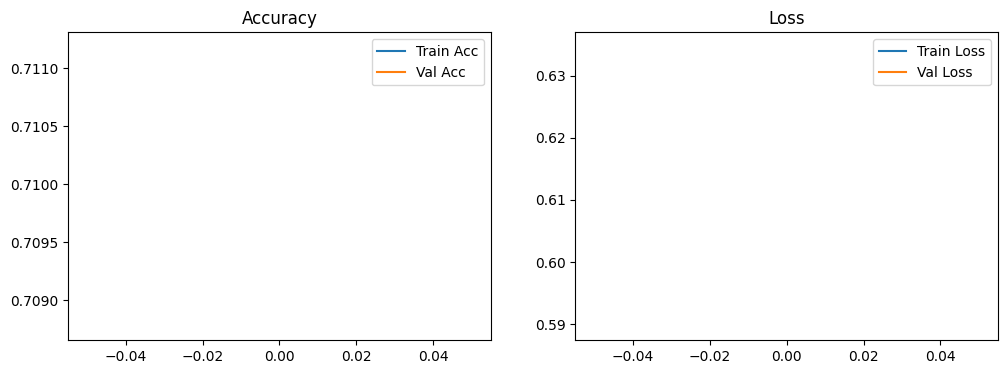

In [25]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss")
plt.legend()
plt.show()
